In [13]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

# sklearn for metrics / splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from pathlib import Path


In [14]:
TEST_DIR = "./dataset/imgs/test"
TRAIN_DIR = "./dataset/imgs/train"
MODEL_PATH = "./model"
PICKLE_PATH = Path("./pickle_files")
TEST_CSV_PATH = "./csv_files/test.csv"
TRAIN_CSV_PATH = "./csv_files/train.csv"

In [15]:
import os
import pickle
import pandas as pd
from tensorflow.keras.utils import to_categorical

# Always safer on Windows:

TRAIN_CSV = pd.read_csv(TRAIN_CSV_PATH)

In [16]:
labels_list = sorted(TRAIN_CSV['ClassName'].unique().tolist())
labels_id = {label_name: i for i, label_name in enumerate(labels_list)}
print(labels_id)

TRAIN_CSV['ClassName'] = TRAIN_CSV['ClassName'].map(labels_id)
labels = to_categorical(TRAIN_CSV['ClassName'])
print(labels.shape)

pickle_file = PICKLE_PATH / "labels_list_vgg16_fine_tuned.pkl"

with open(pickle_file, "wb") as handle:
    pickle.dump(labels_id, handle)

print("Saved:", pickle_file)


{'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4, 'c5': 5, 'c6': 6, 'c7': 7, 'c8': 8, 'c9': 9}
(22424, 10)
Saved: pickle_files\labels_list_vgg16_fine_tuned.pkl


In [17]:
def path_to_tensor(img_path):
    """Load single image and convert to 4D tensor."""
    img_path = str(img_path)  # Windows-safe path
    img = image.load_img(img_path, target_size=(64, 64))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    """Load all image paths → stacked tensor."""
    list_of_tensors = []
    for img_path in tqdm(img_paths, desc="Loading images"):
        list_of_tensors.append(path_to_tensor(img_path))
    return np.vstack(list_of_tensors)

# train-test split
xtrain, xtest, ytrain, ytest = train_test_split(
    TRAIN_CSV.iloc[:, 0].astype(str),   # make sure paths are strings
    labels,
    test_size=0.2,
    random_state=42
)

# convert image paths → images
train_tensors = paths_to_tensor(xtrain).astype("float32") / 255.0 - 0.5
valid_tensors = paths_to_tensor(xtest).astype("float32") / 255.0 - 0.5

Loading images: 100%|██████████| 4485/4485 [00:12<00:00, 351.90it/s]


In [18]:
model = VGG16(include_top=False)
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.output_shape[1:]

(None, None, 512)

In [21]:
vgg16_model_fine_tuned = Sequential()
vgg16_model_fine_tuned.add(GlobalAveragePooling2D(input_shape=model.output_shape[1:]))
vgg16_model_fine_tuned.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))

# Connect head to VGG16 body
vgg16_model_fine_tuned = Model(
    inputs=model.input,
    outputs=vgg16_model_fine_tuned(model.output)
)

vgg16_model_fine_tuned.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,719,818 (56.15 MB)

 Trainable params: 14,719,818 (56.15 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
for layer in vgg16_model_fine_tuned.layers[:15]:
    layer.trainable = False

In [24]:
vgg16_model_fine_tuned.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [33]:
model_dir = Path("./model")
plot_model(
    vgg16_model_fine_tuned,
    to_file=model_dir / "model_distracted_driver_vgg16.png",
    show_shapes=True,
    show_layer_names=True
)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [38]:
from tensorflow.keras.callbacks import ModelCheckpoint
from pathlib import Path

MODEL_PATH = Path(MODEL_PATH)
MODEL_PATH.mkdir(parents=True, exist_ok=True)

filepath = MODEL_PATH / "distracted-{epoch:02d}-{val_accuracy:.2f}.keras"

checkpoint = ModelCheckpoint(
    filepath=str(filepath),
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
)
callbacks_list = [checkpoint]


In [39]:

model_history = vgg16_model_fine_tuned.fit(train_tensors,ytrain,validation_data = (valid_tensors, ytest),epochs=25, batch_size=16, shuffle=True,callbacks=callbacks_list)

Epoch 1/25
1121/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3987 - loss: 1.7879
Epoch 1: val_accuracy improved from -inf to 0.82319, saving model to model\distracted-01-0.82.keras
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 76s 67ms/step - accuracy: 0.3991 - loss: 1.7869 - val_accuracy: 0.8232 - val_loss: 0.5706
Epoch 2/25
1121/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8815 - loss: 0.4239
Epoch 2: val_accuracy improved from 0.82319 to 0.94158, saving model to model\distracted-02-0.94.keras
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 82s 74ms/step - accuracy: 0.8815 - loss: 0.4238 - val_accuracy: 0.9416 - val_loss: 0.2332
Epoch 3/25
1121/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9348 - loss: 0.2353
Epoch 3: val_accuracy improved from 0.94158 to 0.94359, saving model to model\distracted-03-0.94.keras
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 83s 74ms/step - accuracy: 0.9348 - loss: 0.2352 - val_accuracy: 0.9436 - val_loss: 0.1950
Epoch 4/25
1121/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accurac

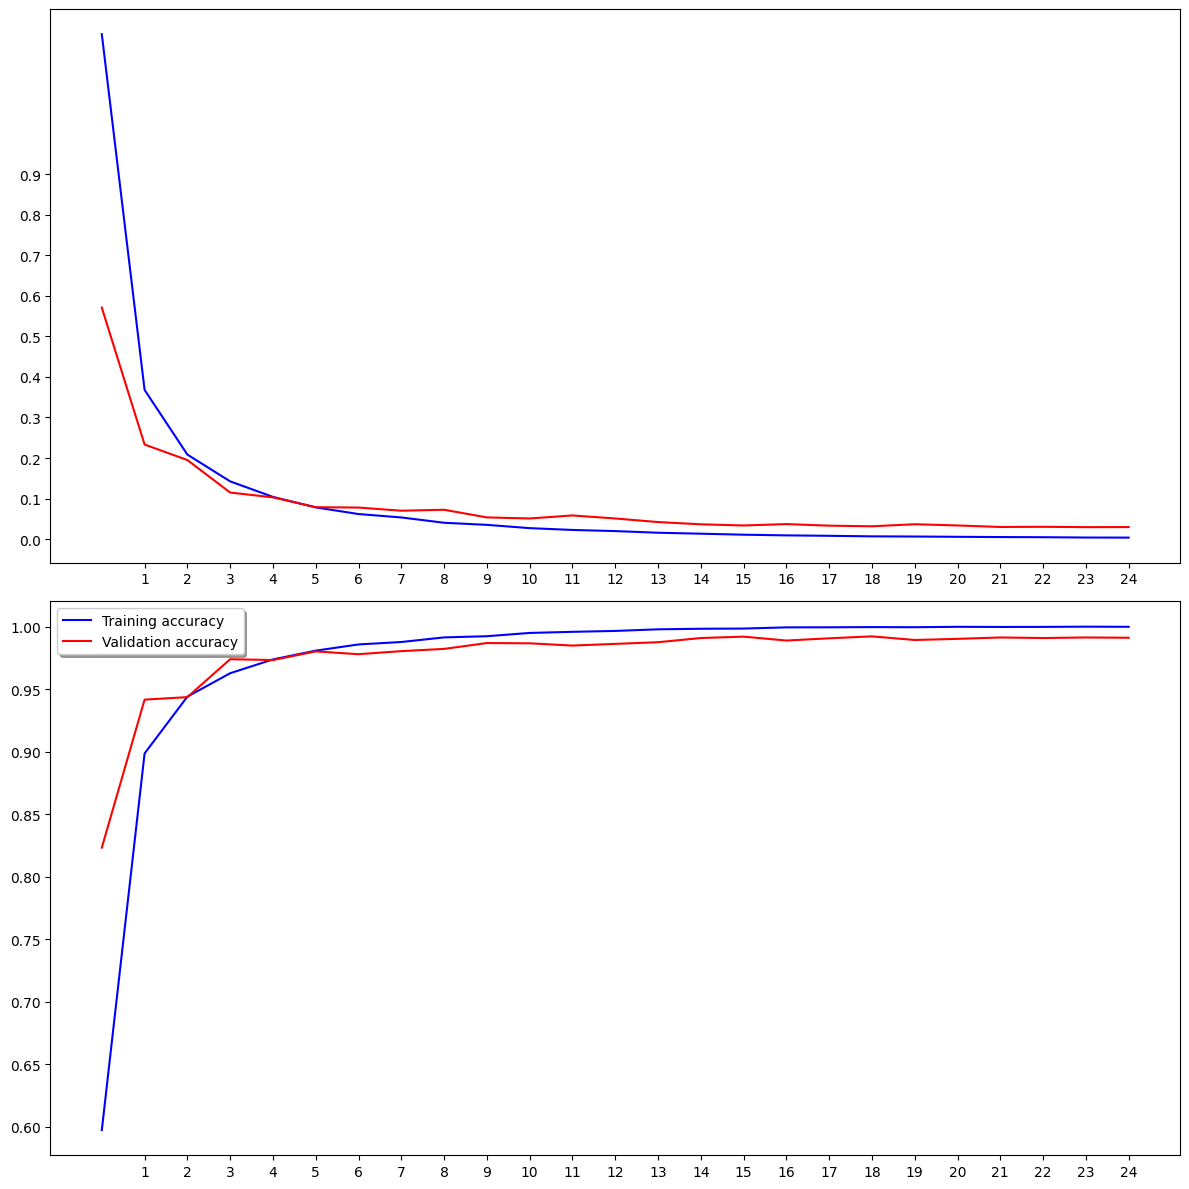

In [41]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 25, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 25, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [42]:
import seaborn as sns
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig

In [71]:
from sklearn.metrics import confusion_matrix
import numpy as np

def print_heatmap(n_labels, n_predictions, class_names):

    # --- FIX 1: Ensure labels are class indices ---
    if n_labels.ndim > 1:
        labels = n_labels.argmax(axis=1)
    else:
        labels = n_labels

    # --- FIX 2: Ensure predictions are class indices ---
    if n_predictions.ndim > 1:
        predictions = n_predictions.argmax(axis=1)
    else:
        predictions = n_predictions

    # --- Compute confusion matrix ---
    matrix = confusion_matrix(labels, predictions)

    # Normalize rows (%)
    row_sum = matrix.sum(axis=1, keepdims=True)
    c_m = (matrix / row_sum * 100).astype(np.uint8)

    # Plot
    heatmap = print_confusion_matrix(c_m, class_names, figsize=(18, 10), fontsize=20)


Loading images: 100%|██████████| 4485/4485 [00:04<00:00, 933.46it/s]


141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step


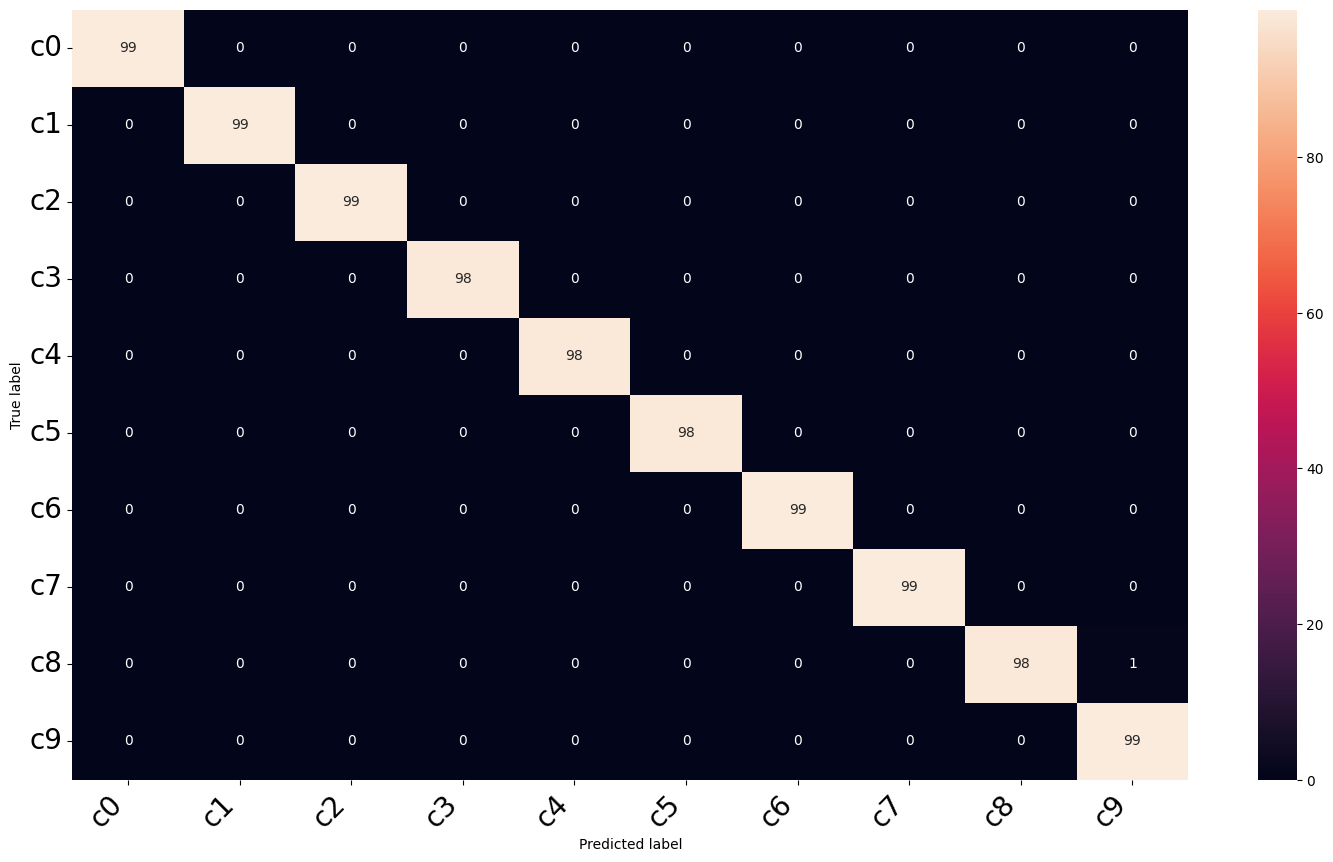

In [72]:
# Correct class names (in label order)
labels_map = {label: idx for idx, label in enumerate(labels_list)}
valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5
class_names = list()
for name,idx in labels_id.items():
    class_names.append(name)
# print(class_names)valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5
ypred = vgg16_model_fine_tuned.predict(valid_tensors, verbose=1)

print_heatmap(ytest, ypred, class_names)



In [80]:
ypred_class = np.argmax(ypred,axis=1)
yval = ytest

In [79]:
from sklearn.metrics import precision_score,recall_score,f1_score
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.991081
Precision: 0.991129
Recall: 0.991081
F1 score: 0.991087
